In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
#import keras
import pandas as pd
#from keras_tqdm import TQDMNotebookCallback


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    records = list(tf.compat.v1.python_io.tf_record_iterator(tfrecord))
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]
    rec_len = len(records)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    laugh_labels = [66, 67] # changed to labels for cheer and applause
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

### Simple Logistic Regression

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

lr_model = Sequential()
#lr_model.add(Dropout(0.2))
lr_model.add(Flatten())
lr_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lr_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
batch_size=128

CV_frac = 0.1
train_gen = data_generator(batch_size,'bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 12657 # find # of records in 'bal_laugh_speech_subset.tfrecord'
lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=1)

Epoch 1/100
88/88 [==============================] - 3s 31ms/step - loss: 13.2153 - accuracy: 0.6958 - val_loss: 7.8218 - val_accuracy: 0.8462
Epoch 2/100
88/88 [==============================] - 2s 20ms/step - loss: 0.2709 - accuracy: 0.9882 - val_loss: 8.0450 - val_accuracy: 0.8462
Epoch 3/100
88/88 [==============================] - 2s 21ms/step - loss: 2.9005e-07 - accuracy: 1.0000 - val_loss: 7.9487 - val_accuracy: 0.8462
Epoch 4/100
88/88 [==============================] - 2s 22ms/step - loss: 2.3853e-07 - accuracy: 1.0000 - val_loss: 7.9400 - val_accuracy: 0.8462
Epoch 5/100
88/88 [==============================] - 2s 22ms/step - loss: 2.1343e-07 - accuracy: 1.0000 - val_loss: 7.9311 - val_accuracy: 0.8462
Epoch 6/100
88/88 [==============================] - 2s 21ms/step - loss: 1.9559e-07 - accuracy: 1.0000 - val_loss: 7.9219 - val_accuracy: 0.8462
Epoch 7/100
88/88 [==============================] - 2s 22ms/step - loss: 1.7322e-07 - accuracy: 1.0000 - val_loss: 7.9130 - val_ac

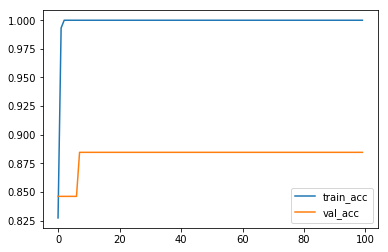

In [7]:
plt.plot(lr_model.history.history['accuracy'], label='train_acc')
plt.plot(lr_model.history.history['val_accuracy'], label='val_acc')
plt.legend()

In [8]:
lr_model.save('../Models/cheer_applause_LR_100Epochs.h5')

In [9]:
tf.keras.__version__

'2.2.4-tf'

In [33]:
from tensorflow.keras.callbacks import History

In [34]:
lstm3_model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])